SCHEDULE

In [6]:
import numpy as np
import simpy
from scipy.stats import expon, norm, gamma
from collections import defaultdict
import matplotlib.pyplot as plt


# -------------------------
# Parameters and distributions
# -------------------------
# Working day: from 8:00 (0 in simulation time) to 17:00 (540 in simulation time)
DAY_LENGTH = 540  # minutes from 8:00 to 17:00
START_TIME = 0     # start of the day (8:00)
END_TIME = DAY_LENGTH  # end of the day (17:00 = 540 minutes after 8:00)
NUM_DAYS = 100     # number of days to simulate

# Patient type 1 parameters
mean_iat_type1 = 33.0  # exponential mean inter-arrival time (minutes)
mean_scan_type1 = 26.0
var_scan_type1 = 36
std_scan_type1 = 6

# Patient type 2 parameters
mean_iat_type2 = 50.0  # normal mean inter-arrival time
var_iat_type2 = 5.0
std_iat_type2 = np.sqrt(var_iat_type2)
mean_scan_type2 = 38.0
var_scan_type2 = 2.0
std_scan_type2 = np.sqrt(var_scan_type2)

# Derived parameters or distributions:
def iat_type1():
    return expon(scale=mean_iat_type1).rvs()

def scan_type1():
    # Normal duration
    return norm(loc=mean_scan_type1, scale=std_scan_type1).rvs()

def iat_type2():
    return norm(loc=mean_iat_type2, scale=std_iat_type2).rvs()

def scan_type2():
    
    shape = mean_scan_type2**2 / var_scan_type2
    scale = var_scan_type2 / mean_scan_type2
    return gamma(a=shape, scale=scale).rvs()

# Fixed time slots to decide (to be experimented with):
slot_length_type1 = 30.0
slot_length_type2 = 20.0

# Number of MRI machines
num_machines_type1 = 1
num_machines_type2 = 1

# -------------------------
# Simulation Model
# -------------------------

class Patient:
    def __init__(self, patient_id, patient_type, arrival_day, arrival_time):
        self.id = patient_id
        self.type = patient_type
        self.arrival_day = arrival_day
        self.arrival_time = arrival_time
        self.scheduled_day = None
        self.scheduled_starttime = None  # Scheduled start time in minutes after 8:00
        self.end_scan_time = None
        self.assigned_machine = None
        self.scan_duration = None
        self.actual_starttime = None
        self.actual_endtime = None

def run_simulation(slot_length_type1, slot_length_type2):
    env = simpy.Environment()
    patients = []
    patient_id = 0  # Unique identifier for each patient

    # Initialize next available slot for each machine type
    next_available_time_type1 = DAY_LENGTH  # Start scheduling from day 1 (next day after day 0)
    next_available_time_type2 = DAY_LENGTH

    next_earliest_scantime1 = 0
    next_earliest_scantime2 = 0

    last_scheduled_day_type1 = None
    last_scheduled_day_type2 = None
    
    def patient_generator_type1(env, patients, machine_type):
        nonlocal patient_id, next_available_time_type1, next_earliest_scantime1, last_scheduled_day_type1
        current_day = 0
        while current_day < NUM_DAYS:
            # Wait for inter-arrival time
            inter_arrival = iat_type1()
            yield env.timeout(inter_arrival)
            
            # Calculate arrival day and time
            total_minutes = env.now
            day = int(total_minutes // DAY_LENGTH)
            time_of_day = total_minutes % DAY_LENGTH
            

            if day >= NUM_DAYS:
                break  # Stop generating after NUM_DAYS

            # Create patient
            patient = Patient(patient_id, 1, day, time_of_day)
            patient_id += 1
            scan_duration = scan_type1()
            # Schedule patient
            # Cannot schedule on the same day, so start from day +1

            if int(next_available_time_type1 // 540) == day:
                next_available_time_type1 = (day + 1)*540
            else:
                pass
                
            scheduled_time = next_available_time_type1

            next_available_time_type1 += slot_length_type1
            if (next_available_time_type1 % 540) > (540 - slot_length_type1):
                next_available_time_type1 += (540 - (next_available_time_type1 % 540))
            else:
                pass
               


            
            
            patient.scheduled_day = int(scheduled_time // DAY_LENGTH)
            patient.scheduled_starttime = scheduled_time % DAY_LENGTH
        
            patient.start_scan_time = scheduled_time
            patient.end_scan_time = scheduled_time + slot_length_type1
            patient.assigned_machine = machine_type
            patient.scan_duration = scan_duration
            
            
            if last_scheduled_day_type1 is None or patient.scheduled_day != last_scheduled_day_type1:
                next_earliest_scantime1 = 0
                last_scheduled_day_type1 = patient.scheduled_day

            # Now compute the actual start time:
            patient.actual_starttime = max(patient.scheduled_starttime, next_earliest_scantime1)
            patient.actual_endtime   = patient.actual_starttime + scan_duration
    
        
            
            next_earliest_scantime1 = patient.actual_starttime + scan_duration
            
            
            

            # Append to patients list
            patients.append(patient)

            

    def patient_generator_type2(env, patients, machine_type):
        nonlocal patient_id, next_available_time_type2, next_earliest_scantime2, last_scheduled_day_type2
        current_day = 0
        while current_day < NUM_DAYS:
            # Wait for inter-arrival time
            inter_arrival = max(iat_type2(), 1.0)
            yield env.timeout(inter_arrival)
            
            # Calculate arrival day and time
            total_minutes = env.now
            day = int(total_minutes // DAY_LENGTH)
            time_of_day = total_minutes % DAY_LENGTH

            if day >= NUM_DAYS:
                break  # Stop generating after NUM_DAYS

            # Create patient
            patient = Patient(patient_id, 2, day, time_of_day)
            patient_id += 1
            scan_duration = scan_type2()

            # Schedule patient
            # Cannot schedule on the same day, so start from day +1

            if int(next_available_time_type2 // 540) == day:
                next_available_time_type2 = (day + 1)*540
            else:
                pass
                
            scheduled_time = next_available_time_type2

            next_available_time_type2 += slot_length_type2
            if (next_available_time_type2 % 540) > (540 - slot_length_type2):
                next_available_time_type2 += (540 - (next_available_time_type2 % 540))
            else:
                pass
            
                
            
            patient.scheduled_day = int(scheduled_time // DAY_LENGTH)
            patient.scheduled_starttime = scheduled_time % DAY_LENGTH
            patient.start_scan_time = scheduled_time
            patient.end_scan_time = scheduled_time + slot_length_type2
            patient.assigned_machine = machine_type
            patient.scan_duration = scan_duration
        
            
            if last_scheduled_day_type2 is None or patient.scheduled_day != last_scheduled_day_type2:
                next_earliest_scantime2 = 0
                last_scheduled_day_type2 = patient.scheduled_day
            
            # Now compute the actual start time:
            patient.actual_starttime = max(patient.scheduled_starttime, next_earliest_scantime2)
            patient.actual_endtime   = patient.actual_starttime + scan_duration
            

        
            
            next_earliest_scantime2 = patient.actual_starttime + scan_duration
            

            

            # Append to patients list
            patients.append(patient)

    # Start patient generators
    env.process(patient_generator_type1(env, patients, 'Machine_Type1'))
    env.process(patient_generator_type2(env, patients, 'Machine_Type2'))

    # Run the simulation
    env.run(until=(NUM_DAYS + 30) * DAY_LENGTH)  # 30 days buffer for scheduling

    # Return the list of patients
    return patients

# Run the simulation and get the list of patients
patients = run_simulation(slot_length_type1, slot_length_type2)

FUNCTIONS

In [16]:

from collections import defaultdict

def get_overtime_and_mean_by_type_and_day(patients):
    

    # 1. Identify the latest end time for each (type, day).
    latest_endtimes = defaultdict(lambda: defaultdict(int))
    for p in patients:
        t = p.type
        d = p.scheduled_day
        e = p.actual_endtime
        if e > latest_endtimes[t][d]:
            latest_endtimes[t][d] = e

    # 2. Calculate day-level overtime for each (type, day).
    overtime_by_type_day = defaultdict(dict)
    for t, day_dict in latest_endtimes.items():
        for d, max_end in day_dict.items():
            overtime_by_type_day[t][d] = max(0, max_end - 540)

    # 3. Calculate the average overtime (across days) for each type.
    average_overtime_by_type = {}
    for t, day_overtime_dict in overtime_by_type_day.items():
        # sum all daily overtimes for this type
        total_overtime = sum(day_overtime_dict.values())
        # number of days for which we have an overtime entry
        num_days = len(day_overtime_dict)
        # compute the average
        average_overtime_by_type[t] = total_overtime / num_days if num_days > 0 else 0

    return overtime_by_type_day, average_overtime_by_type





def calculate_average_wait_times(patients):
    
    total_wait = defaultdict(float)
    count = defaultdict(int)
    
    for patient in patients:
        wait_time = max(0, patient.actual_starttime - patient.scheduled_starttime)
        total_wait[patient.type] += wait_time
        count[patient.type] += 1
    
    average_wait = {}
    for patient_type in total_wait:
        if count[patient_type] > 0:
            average_wait[patient_type] = total_wait[patient_type] / count[patient_type]
        else:
            average_wait[patient_type] = 0.0
    
    return average_wait


def calculate_average_wait_for_appointment_in_days(patients):
   
    total_wait = defaultdict(float)
    count = defaultdict(int)
    
    for patient in patients:
        wait_time = max(0, patient.scheduled_day - patient.arrival_day)
        total_wait[patient.type] += wait_time
        count[patient.type] += 1
    
    average_wait = {}
    for patient_type in total_wait:
        if count[patient_type] > 0:
            average_wait[patient_type] = total_wait[patient_type] / count[patient_type]
        else:
            average_wait[patient_type] = 0.0
    
    return average_wait


def get_system_working_percentages(patients):
    
    # Separate patients by type
    type1_patients = [p for p in patients if p.type == 1]
    type2_patients = [p for p in patients if p.type == 2]

    # Sum of scan durations for each type
    total_scan_duration_type1 = sum(p.scan_duration for p in type1_patients if p.scan_duration)
    total_scan_duration_type2 = sum(p.scan_duration for p in type2_patients if p.scan_duration)

    # Distinct scheduled days for each type
    days_type1 = {p.scheduled_day for p in type1_patients if p.scheduled_day is not None}
    days_type2 = {p.scheduled_day for p in type2_patients if p.scheduled_day is not None}

    # Total time available = (# of distinct scheduled days) * 540 minutes
    total_time_type1 = len(days_type1) * 540
    total_time_type2 = len(days_type2) * 540

    # Calculate utilization percentages (avoid division by zero)
    percentage_type1 = (total_scan_duration_type1 / total_time_type1) if total_time_type1 else 0.0
    percentage_type2 = (total_scan_duration_type2 / total_time_type2) if total_time_type2 else 0.0

    return percentage_type1, percentage_type2



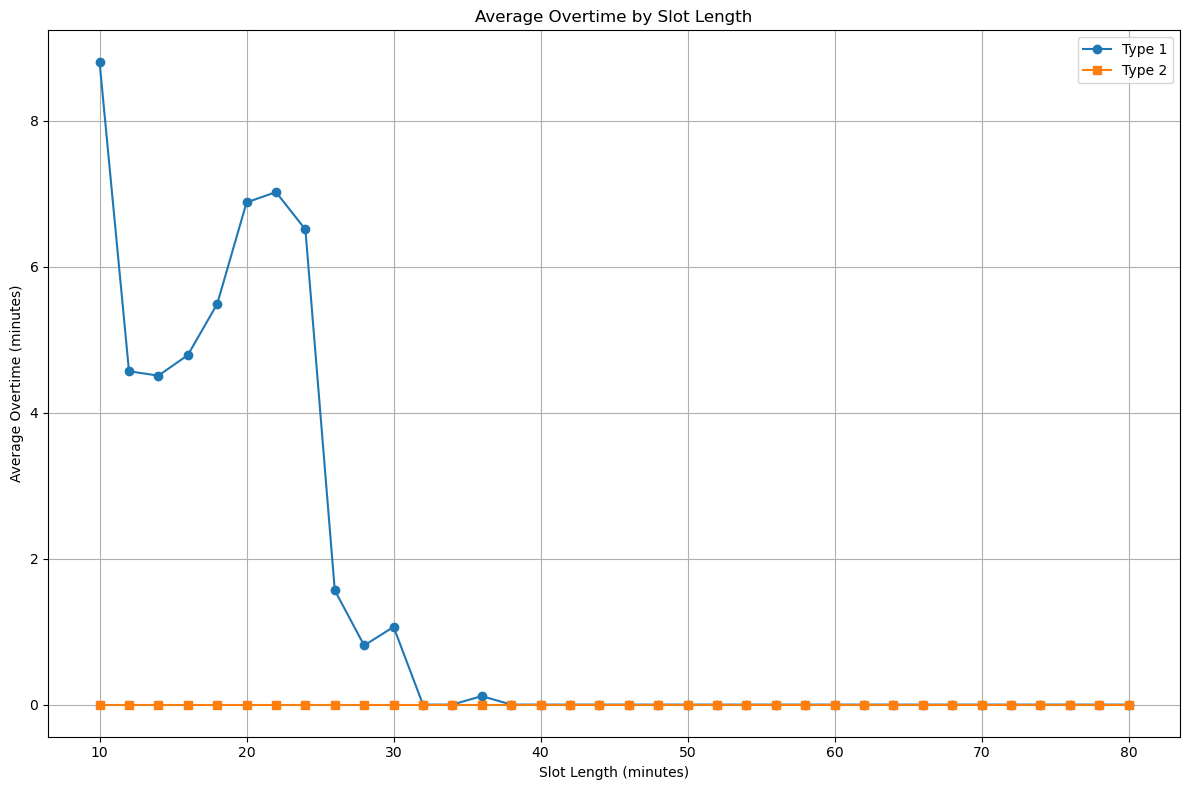

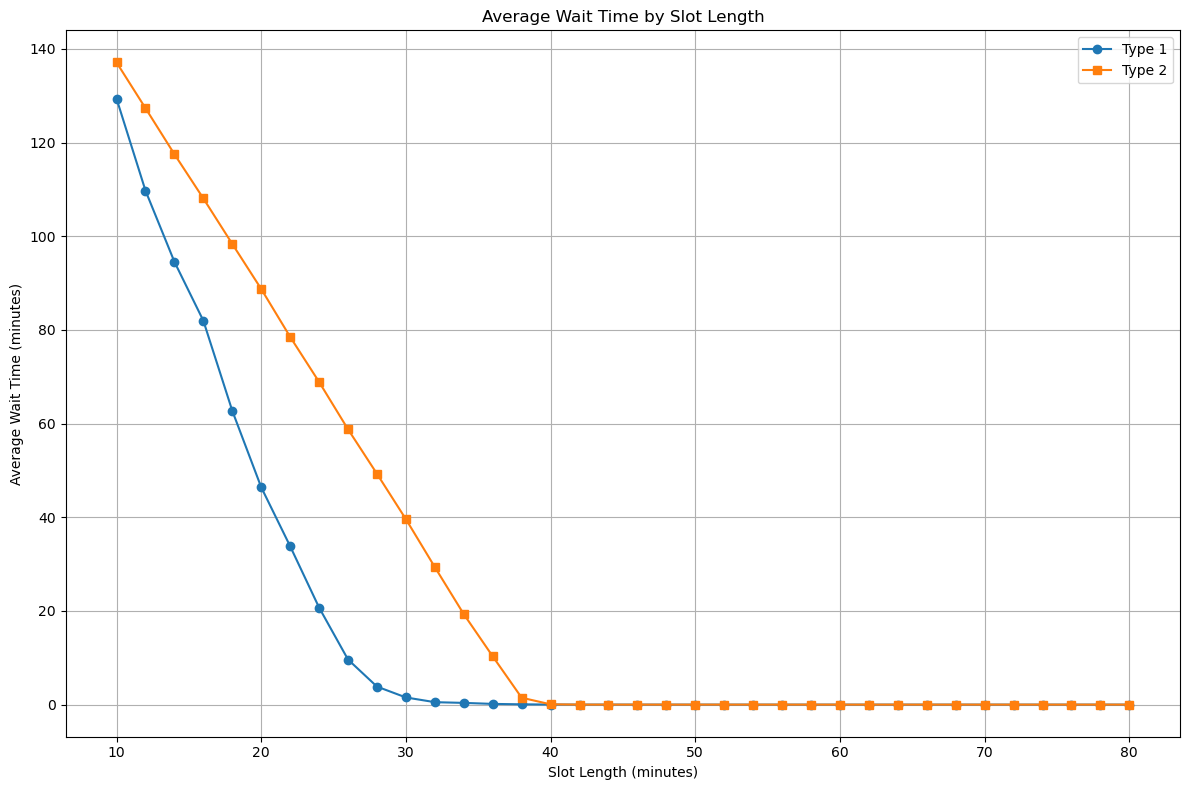

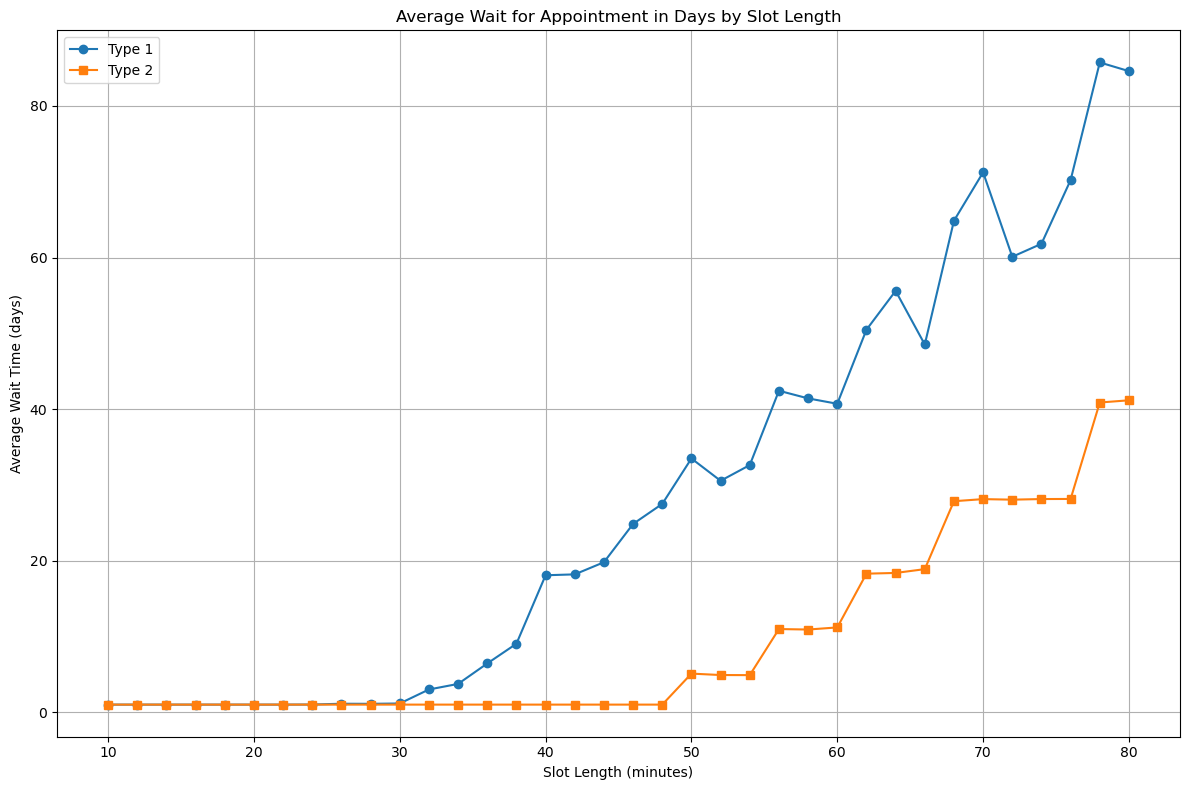

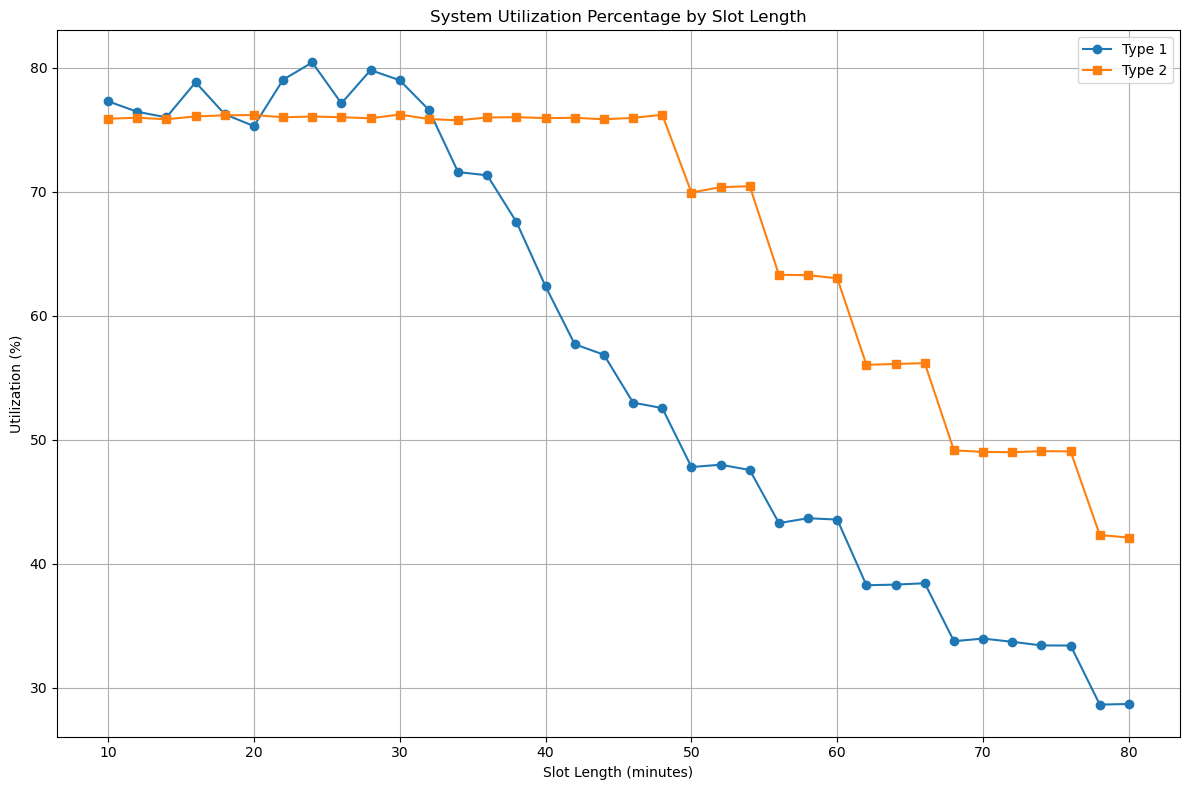

In [20]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


def get_overtime_and_mean_by_type_and_day(patients):
    
    latest_endtimes = defaultdict(lambda: defaultdict(int))
    for p in patients:
        t = p.type
        d = p.scheduled_day
        e = p.actual_endtime
        if e > latest_endtimes[t][d]:
            latest_endtimes[t][d] = e

    overtime_by_type_day = defaultdict(dict)
    for t, day_dict in latest_endtimes.items():
        for d, max_end in day_dict.items():
            overtime_by_type_day[t][d] = max(0, max_end - 540)

    average_overtime_by_type = {}
    for t, day_overtime_dict in overtime_by_type_day.items():
        total_overtime = sum(day_overtime_dict.values())
        num_days = len(day_overtime_dict)
        average_overtime_by_type[t] = total_overtime / num_days if num_days > 0 else 0

    return overtime_by_type_day, average_overtime_by_type

def calculate_average_wait_times(patients):
    total_wait = defaultdict(float)
    count = defaultdict(int)
    
    for patient in patients:
        wait_time = max(0, patient.actual_starttime - patient.scheduled_starttime)
        total_wait[patient.type] += wait_time
        count[patient.type] += 1
    
    average_wait = {}
    for patient_type in total_wait:
        if count[patient_type] > 0:
            average_wait[patient_type] = total_wait[patient_type] / count[patient_type]
        else:
            average_wait[patient_type] = 0.0
    
    return average_wait

def calculate_average_wait_for_appointment_in_days(patients):
    total_wait = defaultdict(float)
    count = defaultdict(int)
    
    for patient in patients:
        wait_time = max(0, patient.scheduled_day - patient.arrival_day)
        total_wait[patient.type] += wait_time
        count[patient.type] += 1
    
    average_wait = {}
    for patient_type in total_wait:
        if count[patient_type] > 0:
            average_wait[patient_type] = total_wait[patient_type] / count[patient_type]
        else:
            average_wait[patient_type] = 0.0
    
    return average_wait

def get_system_working_percentages(patients):
    type1_patients = [p for p in patients if p.type == 1]
    type2_patients = [p for p in patients if p.type == 2]

    total_scan_duration_type1 = sum(p.scan_duration for p in type1_patients if p.scan_duration)
    total_scan_duration_type2 = sum(p.scan_duration for p in type2_patients if p.scan_duration)

    days_type1 = {p.scheduled_day for p in type1_patients if p.scheduled_day is not None}
    days_type2 = {p.scheduled_day for p in type2_patients if p.scheduled_day is not None}

    total_time_type1 = len(days_type1) * 540
    total_time_type2 = len(days_type2) * 540

    percentage_type1 = (total_scan_duration_type1 / total_time_type1) if total_time_type1 else 0.0
    percentage_type2 = (total_scan_duration_type2 / total_time_type2) if total_time_type2 else 0.0

    return percentage_type1, percentage_type2

# Define the range of slot lengths
slot_lengths = range(10, 81, 2)  # 10, 20, ..., 80

# Initialize dictionaries to store metrics for each slot length
metrics = {
    'average_overtime_type1': [],
    'average_overtime_type2': [],
    'average_wait_time_type1': [],
    'average_wait_time_type2': [],
    'average_wait_days_type1': [],
    'average_wait_days_type2': [],
    'system_utilization_type1': [],
    'system_utilization_type2': []
}

# Loop over each slot length and collect metrics
for slot_length in slot_lengths:
    
    slot_length_type1 = slot_length
    slot_length_type2 = slot_length
    
    # Run the simulation
    patients = run_simulation(slot_length_type1, slot_length_type2)
    
    # Calculate metrics
    _, average_overtime = get_overtime_and_mean_by_type_and_day(patients)
    average_wait_time = calculate_average_wait_times(patients)
    average_wait_days = calculate_average_wait_for_appointment_in_days(patients)
    system_utilization = get_system_working_percentages(patients)
    
    # Store metrics, handling cases where a type might not be present
    metrics['average_overtime_type1'].append(average_overtime.get(1, 0))
    metrics['average_overtime_type2'].append(average_overtime.get(2, 0))
    
    metrics['average_wait_time_type1'].append(average_wait_time.get(1, 0))
    metrics['average_wait_time_type2'].append(average_wait_time.get(2, 0))
    
    metrics['average_wait_days_type1'].append(average_wait_days.get(1, 0))
    metrics['average_wait_days_type2'].append(average_wait_days.get(2, 0))
    
    util_type1, util_type2 = system_utilization
    metrics['system_utilization_type1'].append(util_type1)
    metrics['system_utilization_type2'].append(util_type2)

# Plotting the metrics

# 1. Average Overtime by Type
plt.figure(figsize=(12, 8))
plt.plot(slot_lengths, metrics['average_overtime_type1'], marker='o', label='Type 1')
plt.plot(slot_lengths, metrics['average_overtime_type2'], marker='s', label='Type 2')
plt.title('Average Overtime by Slot Length')
plt.xlabel('Slot Length (minutes)')
plt.ylabel('Average Overtime (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Average Wait Time by Type
plt.figure(figsize=(12, 8))
plt.plot(slot_lengths, metrics['average_wait_time_type1'], marker='o', label='Type 1')
plt.plot(slot_lengths, metrics['average_wait_time_type2'], marker='s', label='Type 2')
plt.title('Average Wait Time by Slot Length')
plt.xlabel('Slot Length (minutes)')
plt.ylabel('Average Wait Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Average Wait for Appointment in Days by Type
plt.figure(figsize=(12, 8))
plt.plot(slot_lengths, metrics['average_wait_days_type1'], marker='o', label='Type 1')
plt.plot(slot_lengths, metrics['average_wait_days_type2'], marker='s', label='Type 2')
plt.title('Average Wait for Appointment in Days by Slot Length')
plt.xlabel('Slot Length (minutes)')
plt.ylabel('Average Wait Time (days)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. System Utilization Percentage by Type
plt.figure(figsize=(12, 8))
plt.plot(slot_lengths, [u * 100 for u in metrics['system_utilization_type1']], marker='o', label='Type 1')
plt.plot(slot_lengths, [u * 100 for u in metrics['system_utilization_type2']], marker='s', label='Type 2')
plt.title('System Utilization Percentage by Slot Length')
plt.xlabel('Slot Length (minutes)')
plt.ylabel('Utilization (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import pandas as pd

# Initialize the metrics dictionary
metrics = {
    'average_overtime_type1': [],
    'average_overtime_type2': [],
    'average_wait_time_type1': [],
    'average_wait_time_type2': [],
    'average_wait_days_type1': [],
    'average_wait_days_type2': [],
    'system_utilization_type1': [],
    'system_utilization_type2': []
}

slot_lengths = range(30, 40, 1)

for slot_length in slot_lengths:
    slot_length_type1 = slot_length
    slot_length_type2 = slot_length
    
    # Run the simulation
    patients = run_simulation(slot_length_type1, slot_length_type2)
    
    # Calculate metrics
    _, average_overtime = get_overtime_and_mean_by_type_and_day(patients)
    average_wait_time = calculate_average_wait_times(patients)
    average_wait_days = calculate_average_wait_for_appointment_in_days(patients)
    system_utilization = get_system_working_percentages(patients)
    
    # Store metrics, handling cases where a type might not be present
    metrics['average_overtime_type1'].append(average_overtime.get(1, 0))
    metrics['average_overtime_type2'].append(average_overtime.get(2, 0))
    
    metrics['average_wait_time_type1'].append(average_wait_time.get(1, 0))
    metrics['average_wait_time_type2'].append(average_wait_time.get(2, 0))
    
    metrics['average_wait_days_type1'].append(average_wait_days.get(1, 0))
    metrics['average_wait_days_type2'].append(average_wait_days.get(2, 0))
    
    util_type1, util_type2 = system_utilization
    metrics['system_utilization_type1'].append(util_type1)
    metrics['system_utilization_type2'].append(util_type2)

# Optional: Verify that all lists have the same length
for key, value in metrics.items():
    assert len(value) == len(slot_lengths), f"Length mismatch in {key}"

# Create a DataFrame to store Type 1 metrics
metrics_table_type1 = pd.DataFrame({
    'Slot Length Type1': list(slot_lengths),
    'Average Overtime Type1': metrics['average_overtime_type1'],
    'Average Wait Time Type1': metrics['average_wait_time_type1'],
    'Average Wait Days Type1': metrics['average_wait_days_type1'],
    'System Utilization Type1 (%)': metrics['system_utilization_type1']
})

# Optionally, create a DataFrame for Type 2 metrics
metrics_table_type2 = pd.DataFrame({
    'Slot Length Type2': list(slot_lengths),
    'Average Overtime Type2': metrics['average_overtime_type2'],
    'Average Wait Time Type2': metrics['average_wait_time_type2'],
    'Average Wait Days Type2': metrics['average_wait_days_type2'],
    'System Utilization Type2 (%)': metrics['system_utilization_type2']
})

# Display the tables
print("Type 1 Metrics:")
print(metrics_table_type1)

print("\nType 2 Metrics:")
print(metrics_table_type2)


Type 1 Metrics:
   Slot Length Type1  Average Overtime Type1  Average Wait Time Type1  \
0                 30                0.526272                 1.487479   
1                 31                0.000000                 1.124835   
2                 32                0.000000                 0.715510   
3                 33                0.000000                 0.513112   
4                 34                0.000000                 0.307158   
5                 35                0.000000                 0.177340   
6                 36                0.027124                 0.128666   
7                 37                0.000000                 0.109546   
8                 38                0.000000                 0.053272   
9                 39                0.000000                 0.024472   

   Average Wait Days Type1  System Utilization Type1 (%)  
0                 1.092385                      0.766299  
1                 1.796693                      0.778503  
2  